In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr  4 04:00:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |  15981MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp')  # Change the directory to torchRay-master folder
# %reset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
!pip install keras-flops
from keras_flops import get_flops

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
from tensorflow.keras.utils import plot_model

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten,Conv2D,MaxPooling2D,Dropout
import matplotlib.pyplot as plt

import numpy as np

%load_ext tensorboard
import datetime

In [ ]:
## @test {"output": "ignore"}

def build_teacher_model_fun(show_summary = 0):

    keras.backend.clear_session()
    # Build CNN teacher.
    cnn_model = tf.keras.Sequential(name='teacherNet')

    # your code start from here for stpe 2
    cnn_model.add(Conv2D(filters=32,kernel_size=3,activation='relu',strides=(1,1), padding = 'same', input_shape=(28,28,1)))

    cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1), padding = 'same'))

    cnn_model.add(Conv2D(filters=64,kernel_size=3,activation='relu',strides=(1,1), padding = 'same'))

    cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    # Flatten layer
    cnn_model.add(Flatten())

    cnn_model.add(Dropout(0.5))

    cnn_model.add(Dense(128, activation='relu'))

    cnn_model.add(Dropout(0.5))

    cnn_model.add(Dense(NUM_CLASSES, name='logits'))

    cnn_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

    if(show_summary):
        cnn_model.summary()

    return cnn_model

cnn_model = build_teacher_model_fun(show_summary = 1)

Model: "teacherNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout (Dropout)           (None, 12544)             0

In [ ]:
# Build fully connected student.
def build_student_model_fun(show_summary = 0):

    keras.backend.clear_session()

    fc_model = tf.keras.Sequential(name='studentNet')

    # fc_model.add(MaxPooling2D(pool_size=(1,1),strides=(1,1),input_shape=(28,28,1)))

    # fc_model.add(MaxPooling2D(pool_size=(1,1),strides=(1,1)))

    # your code start from here for step 2
    fc_model.add(Flatten(input_shape=(28,28,1)))

    fc_model.add(Dense(784, activation='relu'))

    fc_model.add(Dense(784, activation='relu'))

    fc_model.add(Dense(NUM_CLASSES, name='logits'))

    fc_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

    if(show_summary):
        fc_model.summary()

    return fc_model

fc_model = build_student_model_fun(show_summary = 1)

Model: "studentNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 784)               615440    
                                                                 
 logits (Dense)              (None, 10)                7850      
                                                                 
 softmax (Activation)        (None, 10)                0         
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


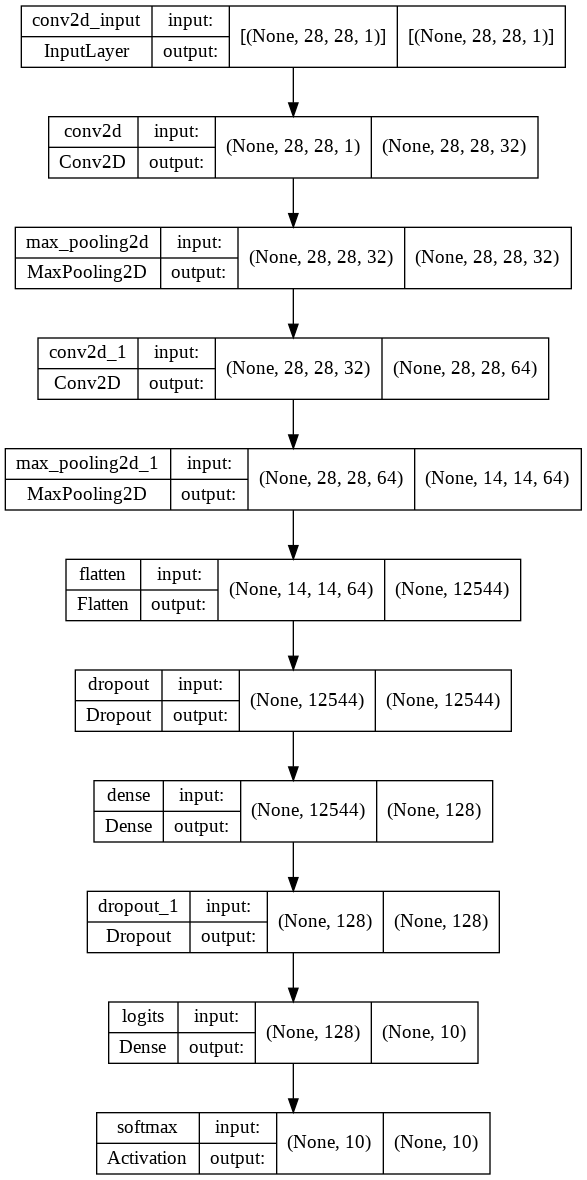

In [ ]:
plot_model(cnn_model, show_shapes=True)

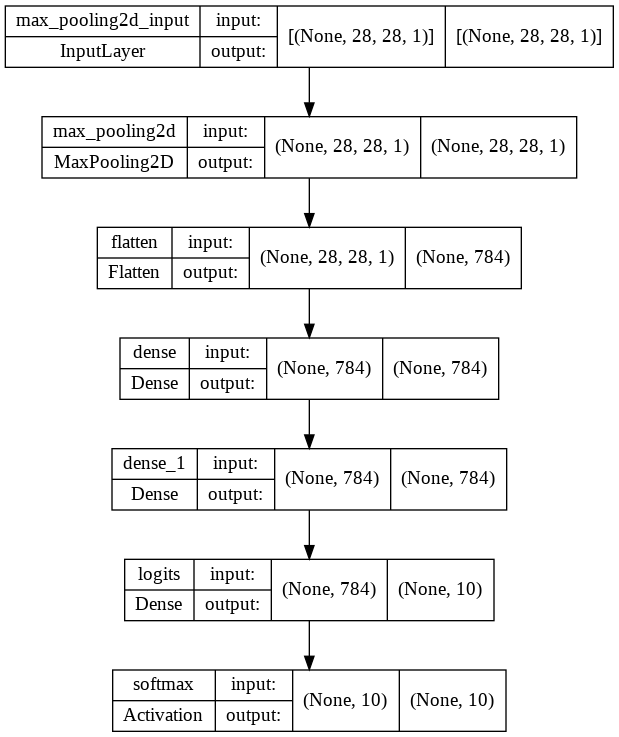

In [ ]:
plot_model(fc_model, show_shapes=True)

# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
    """Compute subclass knowledge distillation teacher loss for given images
        and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    subclass_logits = cnn_model(images, training=True)

    # Compute cross-entropy loss for subclasses.

    # your code start from here for step 3
    #   print(images)
    #   print(labels)
    #   one_hot_y = tf.one_hot([labels], 10)
    # one_hot_y = tf.one_hot(labels, 10)
    #   print("one_hot_y is:", one_hot_y)
    #   print("subclass_logits is:", subclass_logits)
    #   print("one_hot_y dim is:", one_hot_y.shape)

    #   diff = subclass_logits-one_hot_y
    y_pred = tf.clip_by_value(subclass_logits, 1e-7, 1 - 1e-7)
    cross_entropy_loss_value = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))

    # cross_entropy_loss_value = 1/2 * (subclass_logits-one_hot_y)**2
    # cross_entropy_loss_value = tf.reduce_sum(cross_entropy_loss_value)

    # print("Current subclass_logits is:", subclass_logits)
    # print("Current labels is:", labels)
    # print("Current cross_entropy_loss_value is:", cross_entropy_loss_value)

    return cross_entropy_loss_value

# Student loss function

In [ ]:
def softmax_with_temp(logits, temp=1):
    logits = (logits - tf.math.reduce_max(logits)) / temp
    exp_logits = tf.math.exp(logits)
    logits_sum = tf.math.reduce_sum(exp_logits, axis=-1, keepdims=True)
    result = exp_logits / logits_sum
    return result

In [ ]:
# #@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    """Compute distillation loss.

    This function computes cross entropy between softened logits and softened
    targets. The resulting loss is scaled by the squared temperature so that
    the gradient magnitude remains approximately constant as the temperature is
    changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
    a neural network."

    Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
        shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

    Returns:
    A scalar Tensor containing the distillation loss.
    """
    # your code start from here for step 3
    soft_targets = teacher_logits/temperature

    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            soft_targets, student_logits / temperature)) * temperature ** 2

def distillation_loss2(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = softmax_with_temp(teacher_logits,temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def distillation_loss3(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = softmax_with_temp(teacher_logits,temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
    """Compute subclass knowledge distillation student loss for given images
        and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    student_subclass_logits_prob = fc_model(images, training=True)
    student_subclass_logits = fc_model_logits(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits_prob = cnn_model(images, training=False)
    teacher_subclass_logits = cnn_model_logits(images, training=False)

    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)
    distillation_loss_value2 = distillation_loss2(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Compute cross-entropy loss with hard targets.
    y_pred = tf.clip_by_value(student_subclass_logits_prob, 1e-7, 1 - 1e-7)
    origin_loss = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))
    # your code start from here for step 3

    cross_entropy_loss_value = origin_loss + ALPHA*distillation_loss_value2
    # print("In case of formula 1")
    # weight_cal(origin_loss, ALPHA*distillation_loss_value)
    # print("In case of formula 2")
    # weight_cal(origin_loss, ALPHA*distillation_loss_value2)
    # print("\n")

    return cross_entropy_loss_value

def weight_cal(a,b):
    a = a.numpy()
    b = b.numpy()
    absa = abs(a)
    absb = abs(b)
    print("Origin loss is:", a)
    print("Knowledge distallitation loss is:", b)
    print("Origin loss take %s , and knowledge distallitation take %s weight." % (absa/(absa+absb), absb/(absa+absb)))
    print("And the total loss is:", a+b)
    
    return

In [ ]:
# print(distillation_loss(tf.convert_to_tensor([1.1,3.5,7.9]),tf.convert_to_tensor([1.1,3.5,7.9]),2.0))
# my_test_tensor1 = tf.convert_to_tensor([1.1,3.5,7.9])
# my_test_tensor2 = tf.convert_to_tensor([1.1,3.5,7.9])
# my_test_tensor3 = tf.convert_to_tensor([0.0,0.0,1.0])
# print(tf.nn.softmax_cross_entropy_with_logits(my_test_tensor3, my_test_tensor1))
# print(tf.nn.softmax_cross_entropy_with_logits(my_test_tensor1, my_test_tensor3))

tf.Tensor(26.24713, shape=(), dtype=float32)
tf.Tensor(0.013302268, shape=(), dtype=float32)
tf.Tensor(11.493059, shape=(), dtype=float32)


# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Number of correctly classified images.
    """
    class_logits = model(images, training=False)
    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
                tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """

    # your code start from here for step 4
    my_learning_rate = 0.001
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)

    for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.

        print('Epoch {}: '.format(epoch), end='')

        for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                # your code start from here for step 4

                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # optimizer.apply_gradients(zip(grads, fc_model_logits.trainable_variables))

        # Run evaluation.
        total_num_correct = 0
        num_total = builder.info.splits['test'].num_examples
        for images, labels in mnist_test:
            # your code start from here for step 4
            num_correct,_,_ = compute_num_correct(model, images, labels)
            total_num_correct = total_num_correct + num_correct
        print("Class_accuracy: " + '{:.2f}%'.format(
            total_num_correct / num_total * 100))
    return (total_num_correct / num_total * 100)


# Training models

In [ ]:
# your code start from here for step 5 
# build image banch
i=0
for images, labels in mnist_train:
    if (i==0):
        image_batch=images.numpy()
        label_batch=labels.numpy()
    else:
        image_batch=np.vstack([image_batch, images.numpy()])
        label_batch=np.vstack([label_batch, labels.numpy()])
    i = i+1

my_learning_rate = 0.001
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()

log_dir="logs/fit/teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Your code 
cnn_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
history = cnn_model.fit(x = image_batch, y = label_batch, batch_size = BATCH_SIZE, epochs = 12, callbacks=[tensorboard_callback])
cnn_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'-teacher.h5')

Epoch 1/12
234/234 [==============================] - 11s 11ms/step - loss: 0.3240 - accuracy: 0.8975
Epoch 2/12
234/234 [==============================] - 2s 10ms/step - loss: 0.1089 - accuracy: 0.9680
Epoch 3/12
234/234 [==============================] - 2s 11ms/step - loss: 0.0830 - accuracy: 0.9760
Epoch 4/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0704 - accuracy: 0.9789
Epoch 5/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0595 - accuracy: 0.9818
Epoch 6/12
234/234 [==============================] - 3s 11ms/step - loss: 0.0516 - accuracy: 0.9843
Epoch 7/12
234/234 [==============================] - 2s 10ms/step - loss: 0.0486 - accuracy: 0.9855
Epoch 8/12
234/234 [==============================] - 2s 10ms/step - loss: 0.0465 - accuracy: 0.9852
Epoch 9/12
234/234 [==============================] - 2s 11ms/step - loss: 0.0411 - accuracy: 0.9868
Epoch 10/12
234/234 [==============================] - 2s 11ms/step - loss: 0.0394 - accur

In [ ]:
# cnn_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'teacher.h5')

In [ ]:
# cnn_model=load_model('/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp/20220320-201925teacher.h5')

In [ ]:
# %tensorboard --logdir logs/fit

Correct digit: 5
Predicted digit: 5
Confidence score for the correct label: 1.0


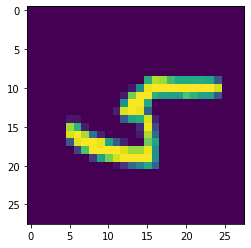

In [ ]:
# test teacher model
index = int(np.floor(np.random.rand()*1000))
input = image_batch[index]
one_hot_label = label_batch[index]
label = np.argmax(label_batch[index])
plt.imshow(input[:,:,0])
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(cnn_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(cnn_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy()[0,label]))

In [ ]:
fc_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
cnn_model_logits = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('logits').output)
fc_model_logits = tf.keras.Model(inputs=fc_model.input, outputs=fc_model.get_layer('logits').output)
cnn_model_logits.summary()
fc_model_logits.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0     

Correct digit: 2
Predicted digit: 4
Confidence score for the correct label: 0.07595505
model output is:  [[0.11331132 0.07005179 0.07595505 0.11480244 0.11899302 0.09729825
  0.08635578 0.09308383 0.11398841 0.11616015]]
logits model output is:  [[ 0.18611938 -0.294785   -0.21387817  0.19919297  0.23504506  0.03376122
  -0.08554398 -0.01051928  0.19207695  0.21095002]]


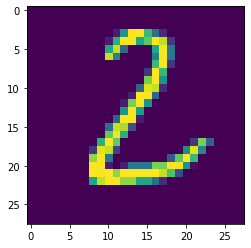

In [ ]:
# test student model
# index = int(np.floor(np.random.rand()*1000))
index = 56
input = image_batch[index]
one_hot_label = label_batch[index]
label = np.argmax(label_batch[index])
plt.imshow(input[:,:,0])
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(fc_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(fc_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy()[0,label]))

print("model output is: ", fc_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())
print("logits model output is: ", fc_model_logits(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())

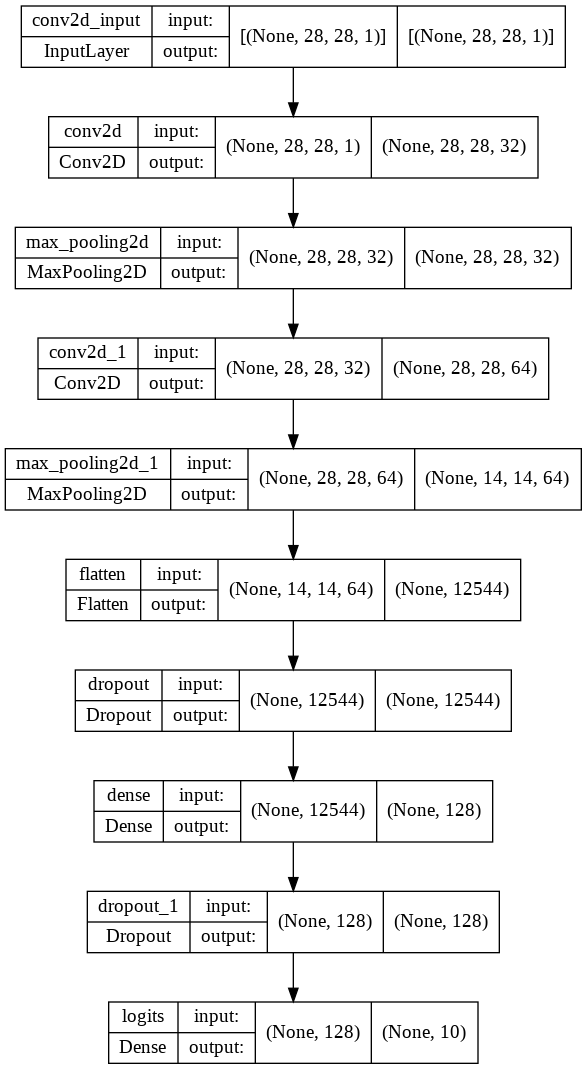

In [ ]:
plot_model(cnn_model_logits, show_shapes=True)

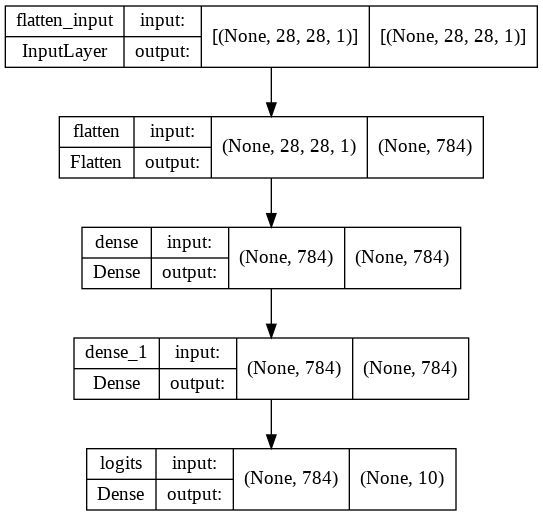

In [ ]:
plot_model(fc_model_logits, show_shapes=True)

In [ ]:
# your code start from here for step 5 
train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.57%
Epoch 2: Class_accuracy: 97.77%
Epoch 3: Class_accuracy: 98.17%
Epoch 4: Class_accuracy: 98.32%
Epoch 5: Class_accuracy: 98.43%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.56%
Epoch 8: Class_accuracy: 98.72%
Epoch 9: Class_accuracy: 98.64%
Epoch 10: Class_accuracy: 98.67%
Epoch 11: Class_accuracy: 98.77%
Epoch 12: Class_accuracy: 98.72%


<tf.Tensor: shape=(), dtype=float32, numpy=98.72>

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
temperature_array = [1.,2.,4.,8.,16.,32.,64.]
class_accuracy_array = []
for t in temperature_array:
    DISTILLATION_TEMPERATURE = t
    fc_model = build_student_model_fun()
    fc_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    fc_model_logits = tf.keras.Model(inputs=fc_model.input, outputs=fc_model.get_layer('logits').output)
    acc = train_and_evaluate(fc_model, compute_student_loss)
    print("In temperature = %s, accuracy after 12 epoch is: %s." %(t,acc))
    class_accuracy_array.append(acc)


Model: "studentNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 784)               615440    
                                                                 
 logits (Dense)              (None, 10)                7850      
                                                                 
 softmax (Activation)        (None, 10)                0         
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1: Class_accuracy: 96.80%
Epoch 2: Class

[98.24 98.53 98.74 98.65 98.68 98.76 98.7 ]


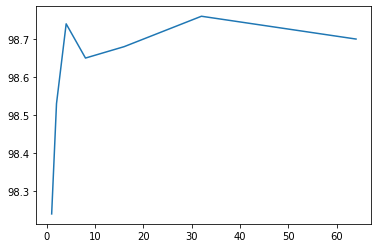

In [ ]:
class_accuracy_array_np = np.array(class_accuracy_array)
print(class_accuracy_array_np)
plt.plot(temperature_array, class_accuracy_array_np)
plt.title("Accuracy vs temperature")

# Train student from scratch

In [ ]:
# Build fully connected student.
# your code start from here for step 7
fc_model_no_distillation = build_student_model_fun()

## @test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
    """Compute plain loss for given images and labels.

    For fair comparison and convenience, this function also performs a
    LogSumExp over subclasses, but does not perform subclass distillation.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    # your code start from here for step 7

    student_subclass_logits_prob = fc_model_no_distillation(images, training=True)

    # Compute cross-entropy loss with hard targets.
    y_pred = tf.clip_by_value(student_subclass_logits_prob, 1e-7, 1 - 1e-7)
    origin_loss = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))
    # your code start from here for step 3

    cross_entropy_loss_value = origin_loss

    return cross_entropy_loss_value

train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.77%
Epoch 2: Class_accuracy: 97.60%
Epoch 3: Class_accuracy: 97.98%
Epoch 4: Class_accuracy: 98.05%
Epoch 5: Class_accuracy: 98.05%
Epoch 6: Class_accuracy: 98.04%
Epoch 7: Class_accuracy: 98.04%
Epoch 8: Class_accuracy: 97.99%
Epoch 9: Class_accuracy: 97.96%
Epoch 10: Class_accuracy: 98.09%
Epoch 11: Class_accuracy: 98.02%
Epoch 12: Class_accuracy: 98.15%


<tf.Tensor: shape=(), dtype=float32, numpy=98.15>

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
# your code start from here for step 8
print("For teacher model:")
flops = get_flops(cnn_model, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")
print("For student model:")
flops = get_flops(fc_model, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")
print("For student model without distillation:")
flops = get_flops(fc_model_no_distillation, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")

For teacher model:
FLOPS: 0.0328G
For student model:
FLOPS: 0.00248G
For student model without distillation:
FLOPS: 0.00248G


# XAI method to explain models

In [ ]:
# your code start from here for step 9
%load_ext autoreload
%autoreload 2
from xai_utils import *


True label:  6
Teacher predicted_label:  6
Teacher confidence score for the correct label: 1.0
Student predicted_label:  6
Student confidence score for the correct label: 1.0
Student no distillation predicted_label:  6
Student no distillation confidence score for the correct label: 0.9999993


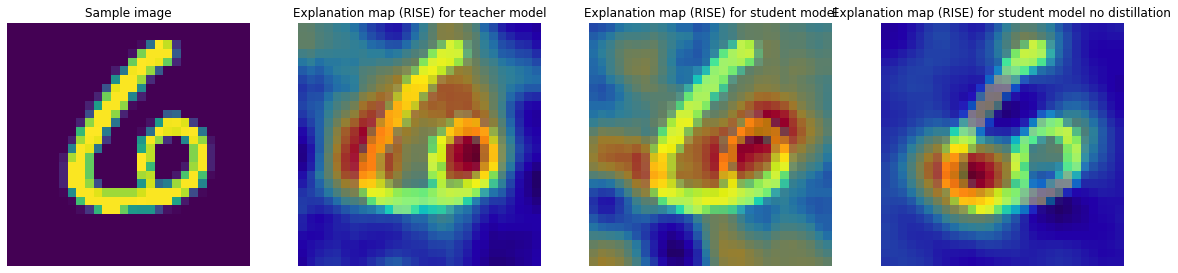

In [ ]:
def my_XAI_test(image_batch, label_batch, index, model1 = cnn_model, model2 = fc_model, model3 = fc_model_no_distillation):

    prediction=model1(image_batch)
    prediction_2=model2(image_batch)
    prediction_3=model3(image_batch)
    print('True label: ',np.argmax(label_batch[index]))
    print('Teacher predicted_label: ',np.argmax(prediction[index]))
    print('Teacher confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
    print('Student predicted_label: ',np.argmax(prediction_2[index]))
    print('Student confidence score for the correct label: '+str(prediction_2[index][np.argmax(label_batch[index])].numpy()))
    print('Student no distillation predicted_label: ',np.argmax(prediction_3[index]))
    print('Student no distillation confidence score for the correct label: '+str(prediction_3[index][np.argmax(label_batch[index])].numpy()))

    explanation_map_RISE = RISE(image_batch[index], model1, class_index=np.argmax(prediction[index]) ,N_MASKS=8000, H = 28, W = 28, C = 1)
    explanation_map_RISE -= explanation_map_RISE.min()
    explanation_map_RISE /= explanation_map_RISE.max()+10e-30

    explanation_map_RISE_2 = RISE(image_batch[index], model2, class_index=np.argmax(prediction[index]) ,N_MASKS=8000, H = 28, W = 28, C = 1)
    explanation_map_RISE_2 -= explanation_map_RISE_2.min()
    explanation_map_RISE_2 /= explanation_map_RISE_2.max()+10e-30

    explanation_map_RISE_3 = RISE(image_batch[index], model3, class_index=np.argmax(prediction[index]) ,N_MASKS=8000, H = 28, W = 28, C = 1)
    explanation_map_RISE_3 -= explanation_map_RISE_3.min()
    explanation_map_RISE_3 /= explanation_map_RISE_3.max()+10e-30

    plt.figure(figsize=(20,5))

    plt.subplot(1,4,1)
    plt.imshow(image_batch[index,:,:,0])
    plt.axis('off')
    plt.title('Sample image')

    plt.subplot(1,4,2)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for teacher model')

    plt.subplot(1,4,3)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE_2, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for student model')

    plt.subplot(1,4,4)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE_3, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for student model no distillation')

my_XAI_test(image_batch[0:256,:,:,:], label_batch[0:256,:], 8)

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 13
epoch_array = [1,2,3,4,5,6,7,8,9,10,11,12]
# epoch_array = [6]
transfer_teacher_model_array = []
transfer_student_model_array = []

my_learning_rate = 0.001
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
log_dir="logs/fit/teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

for epoch_num in epoch_array:
    # log_dir2="logs/fit/HMT_teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
    cnn_model = build_teacher_model_fun()
    cnn_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    fc_model = build_student_model_fun()
    fc_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    cnn_model_logits = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('logits').output)
    fc_model_logits = tf.keras.Model(inputs=fc_model.input, outputs=fc_model.get_layer('logits').output)

    history = cnn_model.fit(x = image_batch, y = label_batch, batch_size = BATCH_SIZE, epochs = epoch_num, callbacks=[tensorboard_callback])
    train_and_evaluate(fc_model, compute_student_loss)

    # test_acc = evaluate_accuracy(hmt_transfer_teacher_model, np_test_set, np_test_label)
    # hmt_transfer_teacher_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ '-epoch-'+str(epoch_num)+'-acc-'+str('{:.2f}'.format(test_acc)) +'-HMTteacher')
    print('In case of train teacher with %s epoch' % epoch_num)
    transfer_teacher_model_array.append(cnn_model)
    transfer_student_model_array.append(fc_model)

234/234 [==============================] - 3s 11ms/step - loss: 0.3047 - accuracy: 0.9061
Epoch 1: Class_accuracy: 96.87%
Epoch 2: Class_accuracy: 97.56%
Epoch 3: Class_accuracy: 97.92%
Epoch 4: Class_accuracy: 98.03%
Epoch 5: Class_accuracy: 97.99%
Epoch 6: Class_accuracy: 98.05%
Epoch 7: Class_accuracy: 98.22%
Epoch 8: Class_accuracy: 98.21%
Epoch 9: Class_accuracy: 98.31%
Epoch 10: Class_accuracy: 98.34%
Epoch 11: Class_accuracy: 98.33%
Epoch 12: Class_accuracy: 98.31%
In case of train teacher with 1 epoch
Epoch 1/2
234/234 [==============================] - 3s 13ms/step - loss: 0.2194 - accuracy: 0.9326
Epoch 2/2
234/234 [==============================] - 2s 10ms/step - loss: 0.0827 - accuracy: 0.9762
Epoch 1: Class_accuracy: 96.79%
Epoch 2: Class_accuracy: 97.87%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.31%
Epoch 5: Class_accuracy: 98.38%
Epoch 6: Class_accuracy: 98.43%
Epoch 7: Class_accuracy: 98.55%
Epoch 8: Class_accuracy: 98.53%
Epoch 9: Class_accuracy: 98.5

In [ ]:
teacher_model_acc_array = []
student_model_acc_array = []
for cnn_model in transfer_teacher_model_array:
    total_num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct,_,_ = compute_num_correct(cnn_model, images, labels)
        total_num_correct = total_num_correct + num_correct
    acc = total_num_correct / num_total * 100
    teacher_model_acc_array.append(acc)

for fc_model in transfer_student_model_array:
    total_num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct,_,_ = compute_num_correct(cnn_model, images, labels)
        total_num_correct = total_num_correct + num_correct
    acc = total_num_correct / num_total * 100
    student_model_acc_array.append(acc)

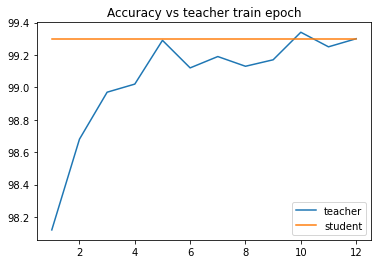

In [ ]:
plt.plot(epoch_array, teacher_model_acc_array, label = 'teacher')
plt.plot(epoch_array, student_model_acc_array, label = 'student')
plt.legend()
plt.title("Accuracy vs teacher train epoch")
plt.show()

# Task 2

In [ ]:
import csv
import pandas as pd


In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp/mhist_dataset/annotations.csv', 'r') as file:
#     reader = csv.reader(file)
    # for row in reader:
    #     print(row)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp/mhist_dataset/annotations.csv')
df

Image Name Majority Vote Label  \
0     MHIST_aaa.png                 SSA   
1     MHIST_aab.png                  HP   
2     MHIST_aac.png                 SSA   
3     MHIST_aae.png                  HP   
4     MHIST_aaf.png                 SSA   
...             ...                 ...   
3147  MHIST_cpn.png                 SSA   
3148  MHIST_cfc.png                 SSA   
3149  MHIST_cgp.png                 SSA   
3150  MHIST_dlf.png                 SSA   
3151  MHIST_cks.png                 SSA   

      Number of Annotators who Selected SSA (Out of 7) Partition  
0                                                    6     train  
1                                                    0     train  
2                                                    5     train  
3                                                    1     train  
4                                                    5     train  
...                                                ...       ...  
3147                                                 7     train  
3148                                                 7      test  
3149                                                 7      test  
3150                                                 7     train  
3151                                                 7     train  

[3152 rows x 4 columns]

In [ ]:
# load and show an image with Pillow
from PIL import Image
# load the image
image = Image.open('/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp/mhist_dataset/images/'+'MHIST_aaa.png')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()

PNG
RGB
(224, 224)


float32
(224, 224, 3)


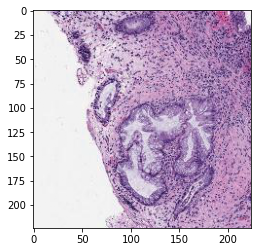

In [ ]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp/mhist_dataset/images/'+'MHIST_aaa.png')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [ ]:
# load all images in a directory
from os import listdir
from matplotlib import image
# load all images in a directory
train_images_SSA = list()
train_images_HP = list()
test_images_SSA = list()
test_images_HP = list()

for filename in listdir('/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp/mhist_dataset/images'):
	# # load image
	# img_data = image.imread('images/' + filename)
	# # store loaded image
	# loaded_images.append(img_data)
	# print('> loaded %s %s' % (filename, img_data.shape))
    img_data = image.imread('/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp/mhist_dataset/images/' + filename)
    # print("file name is:", filename)
    i=df[df['Image Name']==filename]
    if(i['Majority Vote Label'][i.index.values[0]] == 'SSA' and i['Partition'][i.index.values[0]] == 'train'):
        # print('This picture belong to SSA.')
        train_images_SSA.append(img_data)
    elif(i['Majority Vote Label'][i.index.values[0]] == 'SSA' and i['Partition'][i.index.values[0]] == 'test'):
        # print('This picture belong to HP.')
        test_images_SSA.append(img_data)
    elif(i['Majority Vote Label'][i.index.values[0]] == 'HP' and i['Partition'][i.index.values[0]] == 'train'):
        train_images_HP.append(img_data)
    elif(i['Majority Vote Label'][i.index.values[0]] == 'HP' and i['Partition'][i.index.values[0]] == 'test'):
        test_images_HP.append(img_data)
    # if(i['Partition'][i.index.values[0]] == 'train'):
    #     print('This image belong to train set.')
    # elif(i['Partition'][i.index.values[0]] == 'test'):
    #     print('This image belong to test set.')


In [ ]:
# if(df[df['Image Name']=='MHIST_adi.png']['Majority Vote Label'] == 'HP'):
#     print(123)
# i.tovalue

# df.index[df[filename] == True].tolist()
# i.index.values[0]
# print
np_train_HP = np.array(train_images_HP)
np_train_SSA = np.array(train_images_SSA)
np_test_HP = np.array(test_images_HP)
np_test_SSA = np.array(test_images_SSA)
print(np_train_HP.shape)
print(np_train_SSA.shape)
print(np_test_HP.shape)
print(np_test_SSA.shape)

(1545, 224, 224, 3)
(630, 224, 224, 3)
(617, 224, 224, 3)
(360, 224, 224, 3)


In [ ]:
np_train_set = np.vstack((np_train_HP,np_train_SSA))
np_train_label = np.vstack((np.zeros([np_train_HP.shape[0],1]),np.ones([np_train_SSA.shape[0],1])))
np_train_label = tensorflow.keras.utils.to_categorical(np_train_label,2)
np_test_set = np.vstack((np_test_HP,np_test_SSA))
np_test_label = np.vstack((np.zeros([np_test_HP.shape[0],1]),np.ones([np_test_SSA.shape[0],1])))
np_test_label = tensorflow.keras.utils.to_categorical(np_test_label,2)
del np_train_HP
del np_train_SSA
del np_test_HP
del np_test_SSA

del train_images_SSA
del train_images_HP
del test_images_SSA
del test_images_HP

In [ ]:
# np.zeros([np_train_HP.shape[0],1])
# np_train_HP.shape[0]


In [ ]:
full_res_model = tensorflow.keras.applications.ResNet50V2(include_top=True,weights="imagenet",input_shape=(224,224,3))
full_res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
res_model = tensorflow.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_shape=(224,224,3))
for layer in res_model.layers:
    layer.trainable = False

for i, layer in enumerate(res_model.layers):
    print(i, layer.name, "-", layer.trainable)

# keras.backend.clear_session()

# hmt_transfer_teacher_model = tf.keras.Sequential(name='HMTteacherNET')

# hmt_transfer_teacher_model.add(tf.keras.Model(inputs=res_model.input, outputs=res_model.get_layer('post_relu').output))
# hmt_transfer_teacher_model.add(tensorflow.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_shape=(224,224,3)))
# hmt_transfer_teacher_model.add(res_model)


# hmt_transfer_teacher_model.add(Flatten())
# hmt_transfer_teacher_model.add(Dense(1,name='logits'))
# hmt_transfer_teacher_model.add(tf.keras.layers.Activation('sigmoid', name='sigmoid'))

#-------------------------------------------
# hmt_transfer_teacher_model.add(Conv2D(filters=32,kernel_size=3,activation='relu',strides=(1,1), padding = 'same'))

# # hmt_transfer_teacher_model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1), padding = 'same'))

# hmt_transfer_teacher_model.add(Conv2D(filters=64,kernel_size=3,activation='relu',strides=(1,1), padding = 'same'))

# # hmt_transfer_teacher_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

# # Flatten layer
# hmt_transfer_teacher_model.add(Flatten())

# hmt_transfer_teacher_model.add(Dropout(0.5))

# hmt_transfer_teacher_model.add(Dense(128, activation='relu'))

# hmt_transfer_teacher_model.add(Dropout(0.5))

# hmt_transfer_teacher_model.add(Dense(1, name='logits'))

# hmt_transfer_teacher_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

#----------------------------------




# hmt_transfer_teacher_model.summary()

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 pool1_pad - False
4 pool1_pool - False
5 conv2_block1_preact_bn - False
6 conv2_block1_preact_relu - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_pad - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_out - False
17 conv2_block2_preact_bn - False
18 conv2_block2_preact_relu - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_pad - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_out - False
28 conv2_block3_preact_bn - False
29 conv2_block3_preact_relu - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_pad - False
3

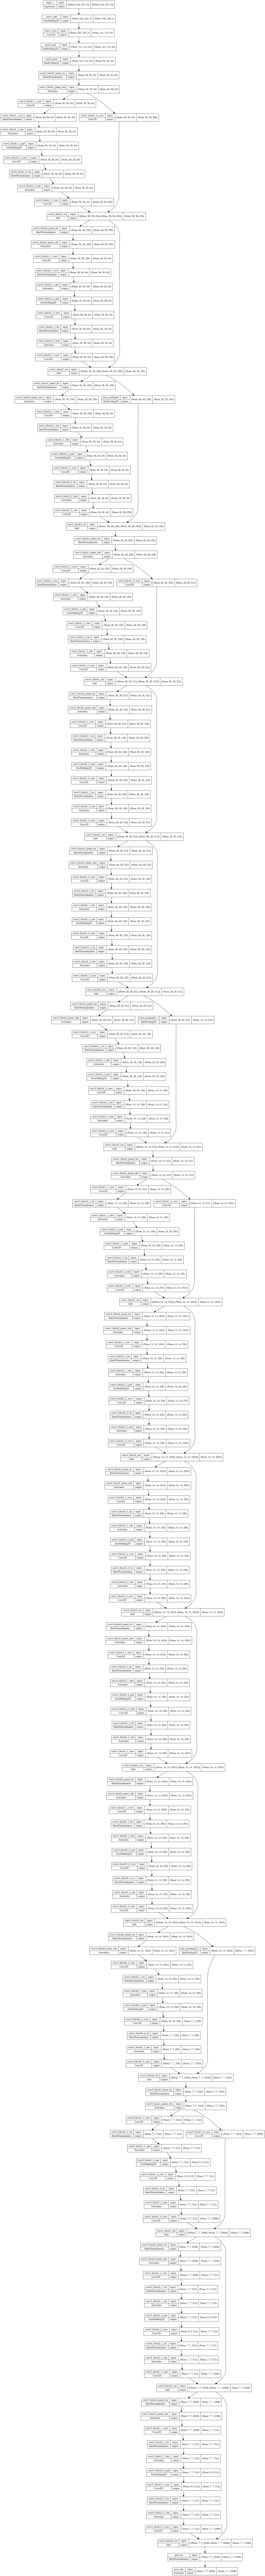

In [ ]:
plot_model(res_model, show_shapes=True)

In [ ]:
def build_HMT_teacher_model_fun(show_summary = 0):

    keras.backend.clear_session()
    # Build CNN teacher.
    hmt_transfer_teacher_model = tf.keras.Sequential(name='HMTteacherNET')

    # your code start from here for stpe 2
    hmt_transfer_teacher_model.add(res_model)


    hmt_transfer_teacher_model.add(Flatten())
    hmt_transfer_teacher_model.add(Dense(2,name='logits'))
    hmt_transfer_teacher_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

    for layer in hmt_transfer_teacher_model.layers:
        if(layer.name == 'resnet50v2'):
            layer.trainable = False

    if(show_summary):
        hmt_transfer_teacher_model.summary()

        for i, layer in enumerate(hmt_transfer_teacher_model.layers):
            print(i, layer.name, "-", layer.trainable)
            

    return hmt_transfer_teacher_model

hmt_transfer_teacher_model = build_HMT_teacher_model_fun(show_summary = 1)

Model: "HMTteacherNET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 logits (Dense)              (None, 2)                 200706    
                                                                 
 softmax (Activation)        (None, 2)                 0         
                                                                 
Total params: 23,765,506
Trainable params: 200,706
Non-trainable params: 23,564,800
_________________________________________________________________
0 resnet50v2 - False
1 flatten - True
2 logits - True
3 softmax - True


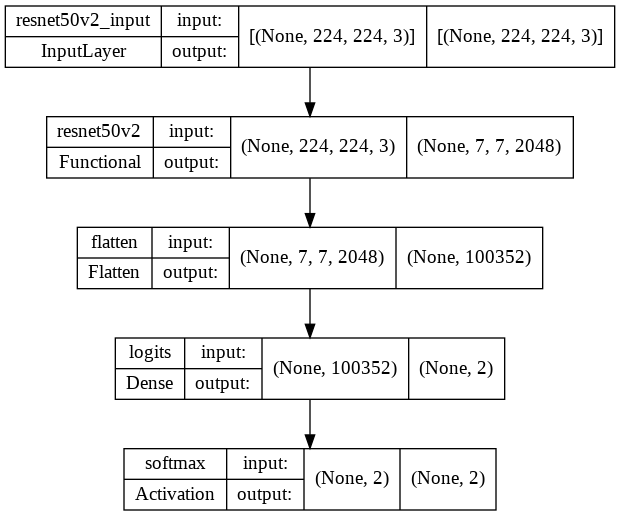

In [ ]:
plot_model(hmt_transfer_teacher_model, show_shapes=True)

In [ ]:
def build_HMT_teacher_model_fun2(show_summary = 0, my_learning_rate = 0.0001):

    keras.backend.clear_session()
    # Build CNN teacher.
    hmt_transfer_teacher_model = tf.keras.Sequential(name='HMTteacherNET')

    # your code start from here for stpe 2
    hmt_transfer_teacher_model.add(res_model)

    hmt_transfer_teacher_model.add(Flatten())
    hmt_transfer_teacher_model.add(Dense(2,name='logits'))
    hmt_transfer_teacher_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

    for layer in hmt_transfer_teacher_model.layers:
        if(layer.name == 'resnet50v2'):
            layer.trainable = False

    my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
    my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
    hmt_transfer_teacher_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])

    hmt_transfer_teacher_model_logits = tf.keras.Model(inputs=hmt_transfer_teacher_model.input, outputs=hmt_transfer_teacher_model.get_layer('logits').output)

    if(show_summary):
        print('For origin teacher model:')
        hmt_transfer_teacher_model.summary()
        print('\nFor logits teacher model:')
        hmt_transfer_teacher_model_logits.summary()
        for i, layer in enumerate(hmt_transfer_teacher_model.layers):
            print(i, layer.name, "-", layer.trainable)
    

    return hmt_transfer_teacher_model, hmt_transfer_teacher_model_logits

hmt_transfer_teacher_model, hmt_transfer_teacher_model_logits = build_HMT_teacher_model_fun2(show_summary = 1)

For origin teacher model:
Model: "HMTteacherNET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 logits (Dense)              (None, 2)                 200706    
                                                                 
 softmax (Activation)        (None, 2)                 0         
                                                                 
Total params: 23,765,506
Trainable params: 200,706
Non-trainable params: 23,564,800
_________________________________________________________________

For logits teacher model:
Model: "model"
_________________________________________________________________
 Layer (type)                Outp

In [ ]:
my_learning_rate = 0.00005
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
log_dir2="logs/fit/HMT_teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

hmt_transfer_teacher_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
history = hmt_transfer_teacher_model.fit(x = np_train_set, y = np_train_label, batch_size = 32, epochs = 12, callbacks=[tensorboard_callback2])
hmt_transfer_teacher_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'-HMTteacher.h5')

Epoch 1/12
68/68 [==============================] - 16s 101ms/step - loss: 0.6458 - accuracy: 0.7480
Epoch 2/12
68/68 [==============================] - 6s 96ms/step - loss: 0.2848 - accuracy: 0.8841
Epoch 3/12
68/68 [==============================] - 7s 97ms/step - loss: 0.1506 - accuracy: 0.9513
Epoch 4/12
68/68 [==============================] - 7s 96ms/step - loss: 0.0920 - accuracy: 0.9857
Epoch 5/12
68/68 [==============================] - 6s 96ms/step - loss: 0.0594 - accuracy: 0.9959
Epoch 6/12
68/68 [==============================] - 6s 95ms/step - loss: 0.0444 - accuracy: 0.9986
Epoch 7/12
68/68 [==============================] - 7s 97ms/step - loss: 0.0329 - accuracy: 0.9995
Epoch 8/12
68/68 [==============================] - 6s 96ms/step - loss: 0.0261 - accuracy: 1.0000
Epoch 9/12
68/68 [==============================] - 6s 96ms/step - loss: 0.0216 - accuracy: 1.0000
Epoch 10/12
68/68 [==============================] - 6s 96ms/step - loss: 0.0183 - accuracy: 1.0000
Epoch 1

In [ ]:
my_learning_rate = 0.0001
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
log_dir2="logs/fit/HMT_teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
hmt_transfer_teacher_model = load_model('/content/drive/MyDrive/Colab Notebooks/1512/Project_B_Supp/20220402-225756-epoch-6-acc-80.45-HMTteacher')

In [ ]:
def evaluate_accuracy(model, dataset, labelset):
    total_num_correct = 0
    num_total = dataset.shape[0]
    for index in range(dataset.shape[0]):
        input = dataset[index]
        label = np.argmax(labelset[index])
        pred_label = np.argmax(model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())
        if(pred_label == label):
            total_num_correct = total_num_correct + 1
    print("Set_accuracy: " + '{:.2f}%'.format(total_num_correct / num_total * 100))
    return (total_num_correct / num_total * 100)

In [ ]:
def evaluate_accuracy2(model, dataset, labelset, batch_size = 32):
    total_num_correct = 0
    num_total = dataset.shape[0]
    for i in range(num_total//batch_size+1):
        begin_index = i*batch_size
        end_index = (i+1)*batch_size
        if(i==num_total//batch_size):
            end_index = num_total
        images = dataset[begin_index:end_index]
        # images = tf.convert_to_tensor(images)
        labels = dataset[begin_index:end_index]
        # labels = tf.convert_to_tensor(labels)
        # your code start from here for step 4
        num_correct,_,_ = compute_num_correct(model, images, labels)
        num_correct = num_correct.np()
        total_num_correct = total_num_correct + num_correct
    acc = total_num_correct / num_total * 100
    return acc

In [ ]:
def compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Number of correctly classified images.
    """
    class_logits = model(images, training=False)
    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
                tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)
def evaluate_accuracy3(model, dataset, labelset):
    total_num_correct = 0
    num_total = dataset.shape[0]
    num_correct,_,_ = compute_num_correct(model, dataset, labelset)
    acc = num_correct / num_total * 100
    return acc

In [ ]:
# images = np_test_set[0:32]
# labels = np_test_label[0:32]
# num_correct,_,_ = compute_num_correct(hmt_transfer_teacher_model, np_test_set, np_test_label)
# print(num_correct)


tf.Tensor(733.0, shape=(), dtype=float32)


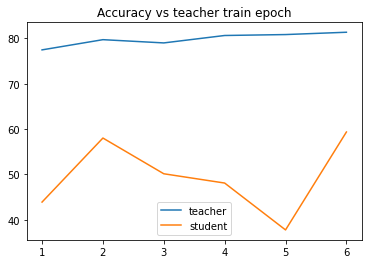

In [ ]:
plt.plot(epoch_array, hmt_transfer_teacher_model_acc, label = 'teacher')
plt.plot(epoch_array, hmt_transfer_student_model_acc, label = 'student')
plt.legend()
plt.title("Accuracy vs teacher train epoch")
plt.show()

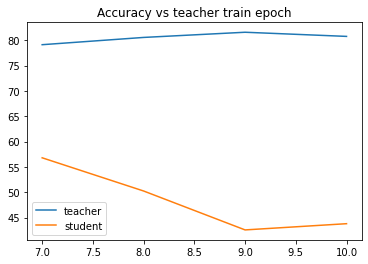

In [ ]:
plt.plot(epoch_array[0:4], hmt_transfer_teacher_model_acc, label = 'teacher')
plt.plot(epoch_array[0:4], hmt_transfer_student_model_acc, label = 'student')
plt.legend()
plt.title("Accuracy vs teacher train epoch")
plt.show()

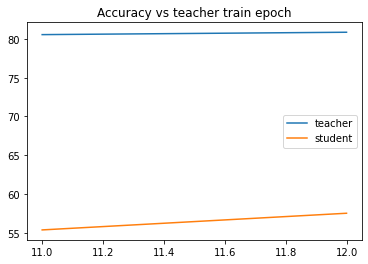

In [ ]:
plt.plot(epoch_array[0:4], hmt_transfer_teacher_model_acc, label = 'teacher')
plt.plot(epoch_array[0:4], hmt_transfer_student_model_acc, label = 'student')
plt.legend()
plt.title("Accuracy vs teacher train epoch")
plt.show()

In [ ]:
# test_acc = evaluate_accuracy(hmt_transfer_teacher_model, np_test_set, np_test_label)
# hmt_transfer_teacher_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ '-epoch-'+str(epoch_num)+'-acc-'+str('{:.2f}'.format(test_acc)) +'-HMTteacher')

Set_accuracy: 80.45%
INFO:tensorflow:Assets written to: 20220402-225756-epoch-6-acc-80.45-HMTteacher/assets


INFO:tensorflow:Assets written to: 20220402-225756-epoch-6-acc-80.45-HMTteacher/assets


In [ ]:
# name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ '-epoch-'+str(epoch_num)+'-acc-'+str('{:.2f}'.format(test_acc)) +'-HMTteacher.h5'
# # name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'-HMTteacher.h5'
# print(name)
# # hmt_transfer_teacher_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ 'epoch_'+str(epoch_num)+'_acc_'+str(test_acc) +'-HMTteacher.h5')
# hmt_transfer_teacher_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ '-epoch-'+str(epoch_num)+'-acc-'+str('{:.2f}'.format(test_acc)) +'-HMTteacher')

20220402-192115-epoch-1-acc-78.40-HMTteacher.h5
INFO:tensorflow:Assets written to: 20220402-192115-epoch-1-acc-78.40-HMTteacher/assets


INFO:tensorflow:Assets written to: 20220402-192115-epoch-1-acc-78.40-HMTteacher/assets


In [ ]:
# train_total_num_correct = 0
# train_num_total = np_train_set.shape[0]
# test_total_num_correct = 0
# test_num_total = np_test_set.shape[0]
# for index in range(np_train_set.shape[0]):
#     input = np_train_set[index]
#     label = np_train_label[index]
#     pred_label = np.round(hmt_transfer_teacher_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())
#     # plt.imshow(input[:,:,0])
#     # print('Correct digit: '+str(label))
#     # print('Predicted digit: '+str(pred_label))
#     # print('Confidence score for the label: '+str(pred_label))
#     if(pred_label == label):
#         train_total_num_correct = train_total_num_correct + 1

# print("Train_Class_accuracy: " + '{:.2f}%'.format(
#     train_total_num_correct / train_num_total * 100))


# for index in range(np_test_set.shape[0]):
#     input = np_test_set[index]
#     label = np_test_label[index]
#     pred_label = np.round(hmt_transfer_teacher_model(np.expand_dims(np.expand_dims(input, axis=0), axis=-1)).numpy())
#     # plt.imshow(input[:,:,0])
#     # print('Correct digit: '+str(label))
#     # print('Predicted digit: '+str(pred_label))
#     # print('Confidence score for the label: '+str(pred_label))
#     if(pred_label == label):
#         test_total_num_correct = test_total_num_correct + 1

# print("Test_Class_accuracy: " + '{:.2f}%'.format(
#     test_total_num_correct / test_num_total * 100))




# #     # your code start from here for step 4
# #     num_correct,_,_ = compute_num_correct(model, images, labels)
# #     total_num_correct = total_num_correct + num_correct
# # print("Class_accuracy: " + '{:.2f}%'.format(
# #     total_num_correct / num_total * 100))

evaluate_accuracy(hmt_transfer_teacher_model, np_test_set, np_test_label)

Set_accuracy: 77.89%


77.89150460593655

In [ ]:
# tensorflow.keras.applications.
# from keras.applications.mobilenet_v2 import MobileNetV2
mobile_model = tensorflow.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,weights="imagenet",input_shape=(224,224,3))
for layer in mobile_model.layers:
    layer.trainable = False

for i, layer in enumerate(mobile_model.layers):
    print(i, layer.name, "-", layer.trainable)



0 input_1 - False
1 Conv1 - False
2 bn_Conv1 - False
3 Conv1_relu - False
4 expanded_conv_depthwise - False
5 expanded_conv_depthwise_BN - False
6 expanded_conv_depthwise_relu - False
7 expanded_conv_project - False
8 expanded_conv_project_BN - False
9 block_1_expand - False
10 block_1_expand_BN - False
11 block_1_expand_relu - False
12 block_1_pad - False
13 block_1_depthwise - False
14 block_1_depthwise_BN - False
15 block_1_depthwise_relu - False
16 block_1_project - False
17 block_1_project_BN - False
18 block_2_expand - False
19 block_2_expand_BN - False
20 block_2_expand_relu - False
21 block_2_depthwise - False
22 block_2_depthwise_BN - False
23 block_2_depthwise_relu - False
24 block_2_project - False
25 block_2_project_BN - False
26 block_2_add - False
27 block_3_expand - False
28 block_3_expand_BN - False
29 block_3_expand_relu - False
30 block_3_pad - False
31 block_3_depthwise - False
32 block_3_depthwise_BN - False
33 block_3_depthwise_relu - False
34 block_3_project - Fal

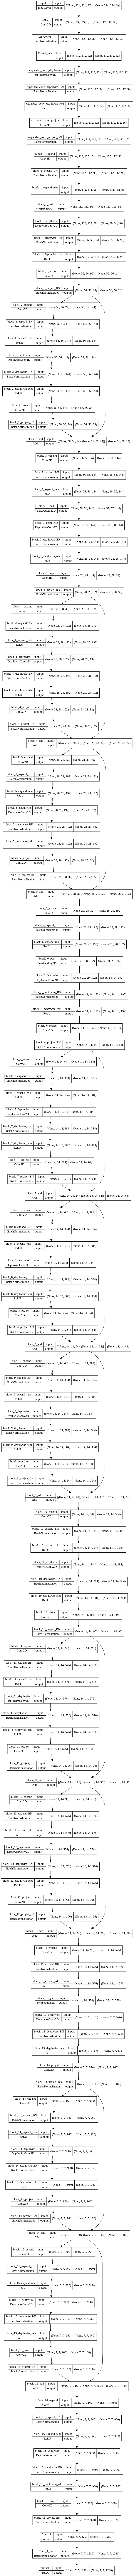

In [ ]:
plot_model(mobile_model, show_shapes=True)

In [ ]:
# hmt_student_model=tf.keras.Sequential()
# hmt_student_model.add(MobileNetV2(include_top=False,weights='imagenet',input_shape=(224,224,3)))

def build_HMT_student_model_fun(show_summary = 0):

    keras.backend.clear_session()
    # Build CNN teacher.
    hmt_student_model = tf.keras.Sequential(name='HMTstudentNET')

    # your code start from here for stpe 2
    hmt_student_model.add(mobile_model)


    hmt_student_model.add(Flatten())
    hmt_student_model.add(Dense(2,name='logits'))
    hmt_student_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

    for layer in hmt_student_model.layers:
        if(layer.name == 'mobilenetv2_1.00_224'):
            layer.trainable = False

    if(show_summary):
        hmt_student_model.summary()

        for i, layer in enumerate(hmt_student_model.layers):
            print(i, layer.name, "-", layer.trainable)

    return hmt_student_model

hmt_transfer_student_model = build_HMT_student_model_fun(show_summary = 1)

Model: "HMTstudentNET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 logits (Dense)              (None, 2)                 125442    
                                                                 
 softmax (Activation)        (None, 2)                 0         
                                                                 
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________
0 mobilenetv2_1.00_224 - False
1 flatten - True
2 logits - True
3 softmax - True


In [ ]:
hmt_transfer_student_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
hmt_transfer_teacher_model_logits = tf.keras.Model(inputs=hmt_transfer_teacher_model.input, outputs=hmt_transfer_teacher_model.get_layer('logits').output)
hmt_transfer_student_model_logits = tf.keras.Model(inputs=hmt_transfer_student_model.input, outputs=hmt_transfer_student_model.get_layer('logits').output)
hmt_transfer_teacher_model_logits.summary()
hmt_transfer_student_model_logits.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2_input (InputLaye  [(None, 224, 224, 3)]    0         
 r)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 logits (Dense)              (None, 2)                 200706    
                                                                 
Total params: 23,765,506
Trainable params: 200,706
Non-trainable params: 23,564,800
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)             

In [ ]:
def build_HMT_student_model_fun2(show_summary = 0, my_learning_rate = 0.0001):

    keras.backend.clear_session()
    # Build CNN teacher.
    hmt_student_model = tf.keras.Sequential(name='HMTstudentNET')

    # your code start from here for stpe 2
    hmt_student_model.add(mobile_model)

    hmt_student_model.add(Flatten())
    hmt_student_model.add(Dense(2,name='logits'))
    hmt_student_model.add(tf.keras.layers.Activation('softmax', name='softmax'))

    for layer in hmt_student_model.layers:
        if(layer.name == 'mobilenetv2_1.00_224'):
            layer.trainable = False

    my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
    my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
    hmt_student_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    hmt_student_model_logits = tf.keras.Model(inputs=hmt_student_model.input, outputs=hmt_student_model.get_layer('logits').output)

    if(show_summary):
        print('For origin student model:')
        hmt_student_model.summary()
        print('\nFor logits student model:')
        hmt_student_model_logits.summary()
        for i, layer in enumerate(hmt_student_model.layers):
            print(i, layer.name, "-", layer.trainable)

    return hmt_student_model, hmt_student_model_logits

hmt_transfer_student_model, hmt_transfer_student_model_logits = build_HMT_student_model_fun2(show_summary = 1)

For origin student model:
Model: "HMTstudentNET"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 logits (Dense)              (None, 2)                 125442    
                                                                 
 softmax (Activation)        (None, 2)                 0         
                                                                 
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________

For logits student model:
Model: "model"
___________________________________

In [ ]:
# #@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter
HMT_BATCH_SIZE = 32
total_train = np_train_set.shape[0]
total_test = np_test_set.shape[0]

def HMT_distillation_loss2(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = softmax_with_temp(teacher_logits,temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def HMT_compute_student_loss(images, labels):
    """Compute subclass knowledge distillation student loss for given images
        and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    student_subclass_logits_prob = hmt_transfer_student_model(images, training=True)
    student_subclass_logits = hmt_transfer_student_model_logits(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits_prob = hmt_transfer_teacher_model(images, training=False)
    teacher_subclass_logits = hmt_transfer_teacher_model_logits(images, training=False)

    distillation_loss_value2 = HMT_distillation_loss2(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Compute cross-entropy loss with hard targets.
    y_pred = tf.clip_by_value(student_subclass_logits_prob, 1e-7, 1 - 1e-7)
    origin_loss = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))
    # your code start from here for step 3

    cross_entropy_loss_value = origin_loss + ALPHA*distillation_loss_value2
    # print("In case of formula 1")
    # weight_cal(origin_loss, ALPHA*distillation_loss_value)
    # print("In case of formula 2")
    # weight_cal(origin_loss, ALPHA*distillation_loss_value2)
    # print("\n")

    return cross_entropy_loss_value

def weight_cal(a,b):
    a = a.numpy()
    b = b.numpy()
    absa = abs(a)
    absb = abs(b)
    print("Origin loss is:", a)
    print("Knowledge distallitation loss is:", b)
    print("Origin loss take %s , and knowledge distallitation take %s weight." % (absa/(absa+absb), absb/(absa+absb)))
    print("And the total loss is:", a+b)
    
    return

In [ ]:
@tf.function
def HMT_compute_num_correct(model, images, labels):
    """Compute number of correctly classified images in a batch.

    Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Number of correctly classified images.
    """
    class_logits = model(images, training=False)
    return tf.reduce_sum(
        tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
                tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def HMT_train_and_evaluate(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """

    # your code start from here for step 4
    my_learning_rate = 0.001
    optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)

    for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.

        print('Epoch {}: '.format(epoch), end='')

        for i in range(total_train//HMT_BATCH_SIZE+1):
            begin_index = i*HMT_BATCH_SIZE
            end_index = (i+1)*HMT_BATCH_SIZE
            if(i==total_train//HMT_BATCH_SIZE):
                end_index = total_train
            images = np_train_set[begin_index:end_index]
            # images = tf.convert_to_tensor(images)
            labels = np_train_label[begin_index:end_index]
            # labels = tf.convert_to_tensor(labels)
            with tf.GradientTape() as tape:
                # your code start from here for step 4

                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # optimizer.apply_gradients(zip(grads, fc_model_logits.trainable_variables))

        # Run evaluation.
        total_num_correct = 0
        num_total = total_test
        for i in range(total_test//HMT_BATCH_SIZE+1):
            begin_index = i*HMT_BATCH_SIZE
            end_index = (i+1)*HMT_BATCH_SIZE
            if(i==total_train//HMT_BATCH_SIZE):
                end_index = total_train
            images = np_test_set[begin_index:end_index,:,:,:]
            labels = np_test_label[begin_index:end_index,:]
            # your code start from here for step 4
            num_correct,_,_ = compute_num_correct(model, images, labels)
            total_num_correct = total_num_correct + num_correct
        print("Class_accuracy: " + '{:.2f}%'.format(
            total_num_correct / num_total * 100))
    return (total_num_correct / num_total * 100)


In [ ]:
@tf.function
def hmt_compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

my_batch_size = 32
def hmt_train_and_evaluate(model, compute_loss_fn):
    """Perform training and evaluation for a given model.

    Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """
    # tf.enable_eager_execution()
    # your code start from here for step 4
    my_learning_rate = 0.001

    # my_learning_rate=0.001/0.1
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
    my_batch_size = 15
    NUM_EPOCHS = 12
    for epoch in range(1, NUM_EPOCHS + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')
        x=0
        y=np_train_set.shape[0]//my_batch_size
        for i in range(y):
      
            images=np_train_set[x:x+my_batch_size]
            labels=np_train_label[x:x+my_batch_size]
            # for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                # your code start from here for step 4

                loss_value = compute_loss_fn(images,labels)
                # print('true true')
                # print(loss_value)
                # print(KD_student_model.trainable_variables)
                # loss_value=loss_value.numpy()
            grads = tape.gradient(loss_value, model.trainable_variables)
            # print('gg')

            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            x=x+my_batch_size
        # Run evaluation.
        # num_correct = 0
        # num_total = builder.info.splits['test'].num_examples
        num_total=np_test_set.shape[0]
        total_num_correct=0

    

        xx=0
        # y=np_train_set.shape[0]//my_batch_size
        for i in range(np_test_set.shape[0]//my_batch_size):
            images=np_test_set[xx:xx+my_batch_size]
            labels=np_test_label[xx:xx+my_batch_size]
            # for images, labels in mnist_test:
            # your code start from here for step 4
            # print(compute_num_correct(model,images,labels))
            num_correct,_,_=hmt_compute_num_correct(model,images,labels)
            xx=xx+my_batch_size

            total_num_correct = total_num_correct+num_correct
        print("Class_accuracy: " + '{:.2f}%'.format(
            total_num_correct / num_total * 100))
    
      


    return ((total_num_correct / num_total * 100).numpy())
# def hmt_train_and_evaluate2(model, compute_loss_fn):
#     """Perform training and evaluation for a given model.

#     Args:
#     model: Instance of tf.keras.Model.
#     compute_loss_fn: A function that computes the training loss given the
#         images, and labels.
#     """
#     # tf.enable_eager_execution()
#     # your code start from here for step 4
#     my_learning_rate = 0.001

#     optimizer = tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)

#     NUM_EPOCHS = 12
#     for epoch in range(1, NUM_EPOCHS + 1):
#         # Run training.
#         print('Epoch {}: '.format(epoch), end='')

#         for i in range(total_train//HMT_BATCH_SIZE+1):
#             begin_index = i*HMT_BATCH_SIZE
#             end_index = (i+1)*HMT_BATCH_SIZE
#             if(i==total_train//HMT_BATCH_SIZE):
#                 end_index = total_train
#             images = np_train_set[begin_index:end_index]
#             labels = np_train_label[begin_index:end_index]
#             with tf.GradientTape() as tape:
#                 # your code start from here for step 4

#                 loss_value = compute_loss_fn(images,labels)
#                 # print('true true')
#                 # print(loss_value)
#                 # print(KD_student_model.trainable_variables)
#                 # loss_value=loss_value.numpy()
#             grads = tape.gradient(loss_value, model.trainable_variables)
#             optimizer.apply_gradients(zip(grads, model.trainable_variables))
#         num_total=np_test_set.shape[0]
#         total_num_correct=0

    

#         total_num_correct = 0
#         num_total = total_test
#         for i in range(total_test//HMT_BATCH_SIZE+1):
#             begin_index = i*HMT_BATCH_SIZE
#             end_index = (i+1)*HMT_BATCH_SIZE
#             if(i==total_test//HMT_BATCH_SIZE):
#                 end_index = total_test
#             images = np_test_set[begin_index:end_index,:,:,:]
#             labels = np_test_label[begin_index:end_index,:]
#             num_correct,_,_=hmt_compute_num_correct(model,images,labels)
#             total_num_correct = total_num_correct+num_correct
#         print("Class_accuracy: " + '{:.2f}%'.format(
#             total_num_correct / num_total * 100))
    
      


#     return ((total_num_correct / num_total * 100).numpy())

In [ ]:
HMT_BATCH_SIZE = 32
def hmt_train_and_evaluate2(model, compute_loss_fn, NUM_EPOCHS = 12):
    """Perform training and evaluation for a given model.

    Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """
    # your code start from here for step 4
    my_learning_rate = 0.0001

    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)

    # NUM_EPOCHS = 12
    for epoch in range(1, NUM_EPOCHS + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')

        for i in range(total_train//HMT_BATCH_SIZE+1):
            begin_index = i*HMT_BATCH_SIZE
            end_index = (i+1)*HMT_BATCH_SIZE
            if(i==total_train//HMT_BATCH_SIZE):
                end_index = total_train
            images = np_train_set[begin_index:end_index]
            labels = np_train_label[begin_index:end_index]
            with tf.GradientTape() as tape:
                # your code start from here for step 4
                loss_value = compute_loss_fn(images,labels)
                # print('Current input image shape is: ', images.shape)
                # print("Current loss value is:", loss_value.numpy())
                # print("Current trainable_variables are: ", model.trainable_variables)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        num_total=np_test_set.shape[0]
        total_num_correct=0

    

        total_num_correct = 0
        num_total = total_test
        for i in range(total_test//HMT_BATCH_SIZE+1):
            begin_index = i*HMT_BATCH_SIZE
            end_index = (i+1)*HMT_BATCH_SIZE
            if(i==total_test//HMT_BATCH_SIZE):
                end_index = total_test
            images = np_test_set[begin_index:end_index,:,:,:]
            labels = np_test_label[begin_index:end_index,:]
            num_correct,_,_=hmt_compute_num_correct(model,images,labels)
            total_num_correct = total_num_correct+num_correct
        print("Class_accuracy: " + '{:.2f}%'.format(
            total_num_correct / num_total * 100))
    
      


    return ((total_num_correct / num_total * 100).numpy())

In [ ]:
HMT_BATCH_SIZE = 32
def hmt_train_and_evaluate3(model, compute_loss_fn, NUM_EPOCHS = 12):
    """Perform training and evaluation for a given model.

    Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    """
    # your code start from here for step 4
    my_learning_rate = 0.0001

    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)

    # NUM_EPOCHS = 12
    for epoch in range(1, NUM_EPOCHS + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')

        for i in range(total_train//HMT_BATCH_SIZE+1):
            begin_index = i*HMT_BATCH_SIZE
            end_index = (i+1)*HMT_BATCH_SIZE
            if(i==total_train//HMT_BATCH_SIZE):
                end_index = total_train
            images = np_train_set[begin_index:end_index]
            labels = np_train_label[begin_index:end_index]
            with tf.GradientTape() as tape:
                # your code start from here for step 4
                loss_value = compute_loss_fn(images,labels)
                # print('Current input image shape is: ', images.shape)
                # print("Current loss value is:", loss_value.numpy())
                # print("Current trainable_variables are: ", model.trainable_variables)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
        num_total=np_test_set.shape[0]
        total_num_correct=0

        num_total = total_test

        num_correct,_,_=hmt_compute_num_correct(model,np_test_set,np_test_label)
        print("Class_accuracy: " + '{:.2f}%'.format(
            num_correct / num_total * 100))

    return ((total_num_correct / num_total * 100).numpy())

In [ ]:
# epoch_array = [1,2,3,4,5,6,7,8,9,10,11,12]
# epoch_array = [1,2,3,4,5,6]
# epoch_array = [7,8,9,10,11,12]
# epoch_array = [11,12]
epoch_array = [6]
hmt_transfer_teacher_model_array = []
hmt_transfer_student_model_array = []
hmt_transfer_teacher_model_acc = []
hmt_transfer_student_model_acc = []

my_learning_rate = 0.00005
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
log_dir2="logs/fit/HMT_teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

for epoch_num in epoch_array:
    # log_dir2="logs/fit/HMT_teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
    # del hmt_transfer_teacher_model
    # del hmt_transfer_student_model
    # del hmt_transfer_teacher_model_logits
    # del hmt_transfer_student_model_logits
    hmt_transfer_teacher_model = build_HMT_teacher_model_fun()
    hmt_transfer_teacher_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    history = hmt_transfer_teacher_model.fit(x = np_train_set, y = np_train_label, batch_size = 32, epochs = epoch_num, callbacks=[tensorboard_callback2])

    # teacher_test_acc = evaluate_accuracy3(hmt_transfer_teacher_model, np_test_set, np_test_label)
    hmt_transfer_student_model = build_HMT_student_model_fun()
    hmt_transfer_student_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    hmt_transfer_teacher_model_logits = tf.keras.Model(inputs=hmt_transfer_teacher_model.input, outputs=hmt_transfer_teacher_model.get_layer('logits').output)
    hmt_transfer_student_model_logits = tf.keras.Model(inputs=hmt_transfer_student_model.input, outputs=hmt_transfer_student_model.get_layer('logits').output)
    acc = hmt_train_and_evaluate2(hmt_transfer_student_model, HMT_compute_student_loss)
    # student_test_acc = evaluate_accuracy3(hmt_transfer_student_model, np_test_set, np_test_label)

    # hmt_transfer_teacher_model.save(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+ '-epoch-'+str(epoch_num)+'-acc-'+str('{:.2f}'.format(test_acc)) +'-HMTteacher')
    hmt_transfer_teacher_model_array.append(hmt_transfer_teacher_model)
    hmt_transfer_student_model_array.append(hmt_transfer_student_model)
    # hmt_transfer_teacher_model_acc.append(teacher_test_acc)
    # hmt_transfer_student_model_acc.append(student_test_acc)

Epoch 1/6
68/68 [==============================] - 9s 96ms/step - loss: 0.6558 - accuracy: 0.7393
Epoch 2/6
68/68 [==============================] - 7s 98ms/step - loss: 0.2918 - accuracy: 0.8777
Epoch 3/6
68/68 [==============================] - 6s 96ms/step - loss: 0.1616 - accuracy: 0.9480
Epoch 4/6
68/68 [==============================] - 6s 96ms/step - loss: 0.0926 - accuracy: 0.9830
Epoch 5/6
68/68 [==============================] - 6s 95ms/step - loss: 0.0631 - accuracy: 0.9963
Epoch 6/6
68/68 [==============================] - 6s 95ms/step - loss: 0.0439 - accuracy: 0.9991
Epoch 1: Class_accuracy: 49.44%
Epoch 2: Class_accuracy: 68.58%
Epoch 3: Class_accuracy: 71.14%
Epoch 4: Class_accuracy: 69.19%
Epoch 5: Class_accuracy: 68.07%
Epoch 6: Class_accuracy: 67.96%
Epoch 7: Class_accuracy: 73.59%
Epoch 8: Class_accuracy: 51.59%
Epoch 9: Class_accuracy: 38.08%
Epoch 10: Class_accuracy: 41.04%
Epoch 11: Class_accuracy: 46.98%
Epoch 12: Class_accuracy: 52.92%


In [ ]:
log_dir2="logs/fit/HMT_teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

hmt_transfer_teacher_model, hmt_transfer_teacher_model_logits = build_HMT_teacher_model_fun2()
hmt_transfer_student_model, hmt_transfer_student_model_logits = build_HMT_student_model_fun2()

history = hmt_transfer_teacher_model.fit(x = np_train_set, y = np_train_label, batch_size = 32, epochs = 6, callbacks=[tensorboard_callback2])
acc = hmt_train_and_evaluate2(hmt_transfer_student_model, HMT_compute_student_loss, NUM_EPOCHS=25)

Epoch 1/6
68/68 [==============================] - 9s 96ms/step - loss: 0.6841 - accuracy: 0.7494
Epoch 2/6
68/68 [==============================] - 6s 96ms/step - loss: 0.1904 - accuracy: 0.9200
Epoch 3/6
68/68 [==============================] - 7s 96ms/step - loss: 0.0701 - accuracy: 0.9867
Epoch 4/6
68/68 [==============================] - 7s 97ms/step - loss: 0.0371 - accuracy: 0.9968
Epoch 5/6
68/68 [==============================] - 6s 96ms/step - loss: 0.0231 - accuracy: 1.0000
Epoch 6/6
68/68 [==============================] - 6s 95ms/step - loss: 0.0165 - accuracy: 1.0000
Epoch 1: Class_accuracy: 65.51%
Epoch 2: Class_accuracy: 73.39%
Epoch 3: Class_accuracy: 75.44%
Epoch 4: Class_accuracy: 76.05%
Epoch 5: Class_accuracy: 74.92%
Epoch 6: Class_accuracy: 74.41%
Epoch 7: Class_accuracy: 74.82%
Epoch 8: Class_accuracy: 76.66%
Epoch 9: Class_accuracy: 73.18%
Epoch 10: Class_accuracy: 54.35%
Epoch 11: Class_accuracy: 36.85%
Epoch 12: Class_accuracy: 37.36%
Epoch 13: Class_accuracy:

In [ ]:
epoch_array = [1,2,3,4,5,6,7,8,9,10,11,12]

hmt_transfer_teacher_model_acc = []
hmt_transfer_student_model_acc = []

log_dir2="logs/fit/HMT_teacher" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
for epoch_num in epoch_array:
    hmt_transfer_teacher_model, hmt_transfer_teacher_model_logits = build_HMT_teacher_model_fun2()
    hmt_transfer_student_model, hmt_transfer_student_model_logits = build_HMT_student_model_fun2()

    history = hmt_transfer_teacher_model.fit(x = np_train_set, y = np_train_label, batch_size = 32, epochs = epoch_num, callbacks=[tensorboard_callback2])
    teacher_test_acc = evaluate_accuracy3(hmt_transfer_teacher_model, np_test_set, np_test_label)
    student_test_acc = hmt_train_and_evaluate2(hmt_transfer_student_model, HMT_compute_student_loss, NUM_EPOCHS=8)
    hmt_transfer_teacher_model_acc.append(teacher_test_acc)
    hmt_transfer_student_model_acc.append(student_test_acc)

68/68 [==============================] - 17s 208ms/step - loss: 0.6711 - accuracy: 0.7637
Epoch 1: Class_accuracy: 54.96%
Epoch 2: Class_accuracy: 59.16%
Epoch 3: Class_accuracy: 63.05%
Epoch 4: Class_accuracy: 68.07%
Epoch 5: Class_accuracy: 73.08%
Epoch 6: Class_accuracy: 73.59%
Epoch 7: Class_accuracy: 75.54%
Epoch 8: Class_accuracy: 45.75%
Epoch 1/2
68/68 [==============================] - 17s 197ms/step - loss: 0.6667 - accuracy: 0.7563
Epoch 2/2
68/68 [==============================] - 12s 185ms/step - loss: 0.2050 - accuracy: 0.9177
Epoch 1: Class_accuracy: 45.85%
Epoch 2: Class_accuracy: 62.54%
Epoch 3: Class_accuracy: 72.26%
Epoch 4: Class_accuracy: 71.24%
Epoch 5: Class_accuracy: 68.78%
Epoch 6: Class_accuracy: 66.63%
Epoch 7: Class_accuracy: 66.02%
Epoch 8: Class_accuracy: 65.81%
Epoch 1/3
68/68 [==============================] - 16s 191ms/step - loss: 0.6708 - accuracy: 0.7687
Epoch 2/3
68/68 [==============================] - 11s 167ms/step - loss: 0.1875 - accuracy: 0.929

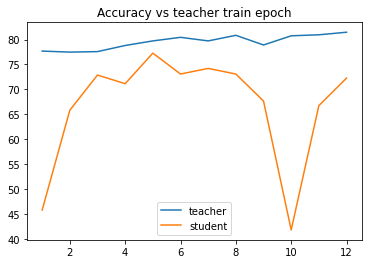

In [ ]:
plt.plot(epoch_array, hmt_transfer_teacher_model_acc, label = 'teacher')
plt.plot(epoch_array, hmt_transfer_student_model_acc, label = 'student')
plt.legend()
plt.title("Accuracy vs teacher train epoch")
plt.show()

In [ ]:
HMT_BATCH_SIZE = 32
hmt_train_and_evaluate2(hmt_transfer_student_model, HMT_compute_student_loss)

Epoch 1: 

InternalError: ignored

In [ ]:
# hmt_transfer_student_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
# hmt_transfer_student_model.fit(x = np_train_set, y = np_train_label, batch_size = 32, epochs = 1, callbacks=[tensorboard_callback2])

In [ ]:
input = np_test_set[0:2,:,:,:]

hmt_transfer_teacher_model(input, training=False)

# hmt_transfer_teacher_model(np.expand_dims(input, axis=0), training=False)

NotFoundError: ignored

In [ ]:
# input = np_test_set[0]
hmt_transfer_teacher_model_logits(input, training=False)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 2.0498495, -1.8748189],
       [ 1.3553307, -3.0347078]], dtype=float32)>

In [ ]:
hmt_transfer_student_model(input, training=False)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.14011738, 0.8598826 ],
       [0.12953427, 0.87046576]], dtype=float32)>

In [ ]:
hmt_transfer_student_model_logits(input, training=False)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.09522786,  1.7190876 ],
       [ 1.4339703 ,  3.3390532 ]], dtype=float32)>

In [ ]:
# your code start from here for step 6
temperature_array = [1.,2.,4.,8.,16.,32.,64.]
class_accuracy_array = []
for t in temperature_array:
    DISTILLATION_TEMPERATURE = t
    hmt_transfer_student_model = build_HMT_student_model_fun()
    hmt_transfer_student_model.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
    hmt_transfer_student_model_logits = tf.keras.Model(inputs=hmt_transfer_student_model.input, outputs=hmt_transfer_student_model.get_layer('logits').output)
    acc = hmt_train_and_evaluate2(hmt_transfer_student_model, HMT_compute_student_loss)
    print("In temperature = %s, accuracy after 12 epoch is: %s." %(t,acc))
    class_accuracy_array.append(acc)

Epoch 1: Class_accuracy: 36.85%
Epoch 2: Class_accuracy: 53.94%
Epoch 3: Class_accuracy: 45.34%
Epoch 4: Class_accuracy: 52.71%
Epoch 5: Class_accuracy: 55.27%
Epoch 6: Class_accuracy: 57.01%
Epoch 7: Class_accuracy: 58.55%
Epoch 8: Class_accuracy: 60.39%
Epoch 9: Class_accuracy: 61.11%
Epoch 10: Class_accuracy: 60.90%
Epoch 11: Class_accuracy: 61.41%
Epoch 12: Class_accuracy: 61.62%
In temperature = 1.0, accuracy after 12 epoch is: 61.617195.
Epoch 1: Class_accuracy: 36.85%
Epoch 2: Class_accuracy: 41.25%
Epoch 3: Class_accuracy: 46.88%
Epoch 4: Class_accuracy: 49.54%
Epoch 5: Class_accuracy: 51.07%
Epoch 6: Class_accuracy: 53.02%
Epoch 7: Class_accuracy: 54.35%
Epoch 8: Class_accuracy: 56.19%
Epoch 9: Class_accuracy: 56.50%
Epoch 10: Class_accuracy: 56.81%
Epoch 11: Class_accuracy: 56.91%
Epoch 12: Class_accuracy: 57.63%
In temperature = 2.0, accuracy after 12 epoch is: 57.62538.
Epoch 1: Class_accuracy: 38.18%
Epoch 2: Class_accuracy: 43.91%
Epoch 3: Class_accuracy: 38.59%
Epoch 4: 

[61.617195 57.62538  37.25691  48.515865 62.026615 57.420677 60.798367]


Text(0.5, 1.0, 'Accuracy vs temperature')

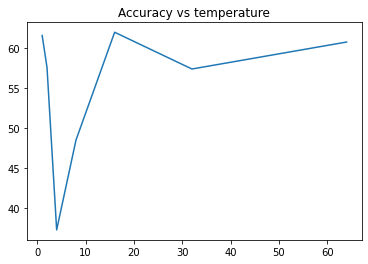

In [ ]:
class_accuracy_array_np = np.array(class_accuracy_array)
print(class_accuracy_array_np)
plt.plot(temperature_array, class_accuracy_array_np)
plt.title("Accuracy vs temperature")

In [ ]:
my_learning_rate = 0.0001
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
hmt_transfer_student_model_no_distillation = build_HMT_student_model_fun()
hmt_transfer_student_model_no_distillation.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
## @test {"output": "ignore"}

def HMT_compute_plain_cross_entropy_loss(images, labels):
    """Compute plain loss for given images and labels.

    For fair comparison and convenience, this function also performs a
    LogSumExp over subclasses, but does not perform subclass distillation.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    # your code start from here for step 7

    student_subclass_logits_prob = hmt_transfer_student_model_no_distillation(images, training=True)

    # Compute cross-entropy loss with hard targets.
    y_pred = tf.clip_by_value(student_subclass_logits_prob, 1e-7, 1 - 1e-7)
    origin_loss = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))
    # your code start from here for step 3

    cross_entropy_loss_value = origin_loss

    return cross_entropy_loss_value

hmt_train_and_evaluate2(hmt_transfer_student_model_no_distillation, HMT_compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 63.15%
Epoch 3: Class_accuracy: 63.15%
Epoch 4: Class_accuracy: 63.15%
Epoch 5: Class_accuracy: 63.15%
Epoch 6: Class_accuracy: 63.15%
Epoch 7: Class_accuracy: 63.15%
Epoch 8: Class_accuracy: 63.15%
Epoch 9: Class_accuracy: 63.15%
Epoch 10: Class_accuracy: 63.15%
Epoch 11: Class_accuracy: 63.15%
Epoch 12: Class_accuracy: 63.15%


63.15251

In [ ]:
my_learning_rate = 0.0001
my_optimizer=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
my_loss_func=tensorflow.keras.losses.CategoricalCrossentropy()
hmt_transfer_student_model_no_distillation = build_HMT_student_model_fun()
hmt_transfer_student_model_no_distillation.compile(optimizer=my_optimizer, loss=my_loss_func, metrics=['accuracy'])
hmt_transfer_student_model_no_distillation.fit(x = np_train_set, y = np_train_label, batch_size = 32, epochs = 12, callbacks=[tensorboard_callback2])

Epoch 1/12
68/68 [==============================] - 6s 49ms/step - loss: 0.6564 - accuracy: 0.7577
Epoch 2/12
68/68 [==============================] - 3s 47ms/step - loss: 0.2841 - accuracy: 0.8860
Epoch 3/12
68/68 [==============================] - 3s 47ms/step - loss: 0.1452 - accuracy: 0.9499
Epoch 4/12
68/68 [==============================] - 3s 47ms/step - loss: 0.0837 - accuracy: 0.9821
Epoch 5/12
68/68 [==============================] - 3s 47ms/step - loss: 0.0483 - accuracy: 0.9972
Epoch 6/12
68/68 [==============================] - 3s 47ms/step - loss: 0.0330 - accuracy: 1.0000
Epoch 7/12
68/68 [==============================] - 3s 47ms/step - loss: 0.0254 - accuracy: 1.0000
Epoch 8/12
68/68 [==============================] - 3s 47ms/step - loss: 0.0202 - accuracy: 1.0000
Epoch 9/12
68/68 [==============================] - 3s 48ms/step - loss: 0.0170 - accuracy: 1.0000
Epoch 10/12
68/68 [==============================] - 3s 47ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 11/

In [ ]:
hmt_transfer_student_model_no_distillation = build_HMT_student_model_fun()

## @test {"output": "ignore"}

def HMT_compute_plain_cross_entropy_loss(images, labels):
    """Compute plain loss for given images and labels.

    For fair comparison and convenience, this function also performs a
    LogSumExp over subclasses, but does not perform subclass distillation.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

    Returns:
    Scalar loss Tensor.
    """
    # your code start from here for step 7

    student_subclass_logits_prob = hmt_transfer_student_model_no_distillation(images, training=True)

    # Compute cross-entropy loss with hard targets.
    y_pred = tf.clip_by_value(student_subclass_logits_prob, 1e-7, 1 - 1e-7)
    origin_loss = -tf.math.reduce_mean(tf.math.reduce_sum(labels * tf.math.log(y_pred), axis=-1, keepdims=False))
    # your code start from here for step 3

    cross_entropy_loss_value = origin_loss

    return cross_entropy_loss_value

hmt_train_and_evaluate2(hmt_transfer_student_model_no_distillation, HMT_compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 63.15%
Epoch 2: Class_accuracy: 63.15%
Epoch 3: Class_accuracy: 63.15%
Epoch 4: Class_accuracy: 63.15%
Epoch 5: Class_accuracy: 63.15%
Epoch 6: Class_accuracy: 63.15%
Epoch 7: Class_accuracy: 63.15%
Epoch 8: Class_accuracy: 63.15%
Epoch 9: Class_accuracy: 63.15%
Epoch 10: Class_accuracy: 63.15%
Epoch 11: Class_accuracy: 63.15%
Epoch 12: Class_accuracy: 63.15%


63.15251

In [ ]:
print("For teacher model:")
flops = get_flops(hmt_transfer_teacher_model, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")
print("For student model:")
flops = get_flops(hmt_transfer_student_model, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")
print("For student model without distillation:")
flops = get_flops(hmt_transfer_student_model_no_distillation, batch_size = 1)
print(f"FLOPS: {flops / 10 ** 9:.03}G")

For teacher model:
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


FLOPS: 6.99G
For student model:
FLOPS: 0.613G
For student model without distillation:
FLOPS: 0.613G


True label:  0
Teacher predicted_label:  0
Teacher confidence score for the correct label: 0.99927515
Student predicted_label:  0
Student confidence score for the correct label: 0.9973767
Student no distillation predicted_label:  0
Student no distillation confidence score for the correct label: 0.99989843


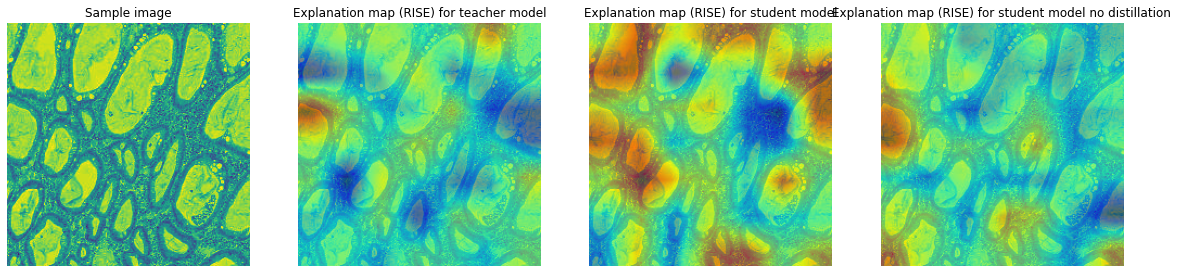

In [ ]:
def my_HMT_XAI_test(image_batch, label_batch, index, model1 = hmt_transfer_teacher_model, model2 = hmt_transfer_student_model, model3 = hmt_transfer_student_model_no_distillation):

    prediction=model1(image_batch)
    prediction_2=model2(image_batch)
    prediction_3=model3(image_batch)
    print('True label: ',np.argmax(label_batch[index]))
    print('Teacher predicted_label: ',np.argmax(prediction[index]))
    print('Teacher confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
    print('Student predicted_label: ',np.argmax(prediction_2[index]))
    print('Student confidence score for the correct label: '+str(prediction_2[index][np.argmax(label_batch[index])].numpy()))
    print('Student no distillation predicted_label: ',np.argmax(prediction_3[index]))
    print('Student no distillation confidence score for the correct label: '+str(prediction_3[index][np.argmax(label_batch[index])].numpy()))

    explanation_map_RISE = RISE(image_batch[index], model1, class_index=np.argmax(prediction[index]) ,N_MASKS=1000, H = 224, W = 224, C = 3)
    explanation_map_RISE -= explanation_map_RISE.min()
    explanation_map_RISE /= explanation_map_RISE.max()+10e-30

    explanation_map_RISE_2 = RISE(image_batch[index], model2, class_index=np.argmax(prediction[index]) ,N_MASKS=1000, H = 224, W = 224, C = 3)
    explanation_map_RISE_2 -= explanation_map_RISE_2.min()
    explanation_map_RISE_2 /= explanation_map_RISE_2.max()+10e-30

    explanation_map_RISE_3 = RISE(image_batch[index], model3, class_index=np.argmax(prediction[index]) ,N_MASKS=1000, H = 224, W = 224, C = 3)
    explanation_map_RISE_3 -= explanation_map_RISE_3.min()
    explanation_map_RISE_3 /= explanation_map_RISE_3.max()+10e-30

    plt.figure(figsize=(20,5))

    plt.subplot(1,4,1)
    plt.imshow(image_batch[index,:,:,0])
    plt.axis('off')
    plt.title('Sample image')

    plt.subplot(1,4,2)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for teacher model')

    plt.subplot(1,4,3)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE_2, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for student model')

    plt.subplot(1,4,4)
    plt.imshow(image_batch[index,:,:,0])
    plt.imshow(explanation_map_RISE_3, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE) for student model no distillation')

my_HMT_XAI_test(np_train_set[0:10,:,:,:], np_train_label[0:10,:], 3)


True label:  0
Teacher predicted_label:  0
Teacher confidence score for the correct label: 0.9813362
Student predicted_label:  1
Student confidence score for the correct label: 0.047829967
Student no distillation predicted_label:  0
Student no distillation confidence score for the correct label: 0.99721885
True label:  0
Teacher predicted_label:  0
Teacher confidence score for the correct label: 0.94456625
Student predicted_label:  1
Student confidence score for the correct label: 0.04947478
Student no distillation predicted_label:  0
Student no distillation confidence score for the correct label: 0.970138
True label:  0
Teacher predicted_label:  0
Teacher confidence score for the correct label: 0.9958676
Student predicted_label:  0
Student confidence score for the correct label: 0.6013417
Student no distillation predicted_label:  0
Student no distillation confidence score for the correct label: 0.9992143
True label:  0
Teacher predicted_label:  0
Teacher confidence score for the corre

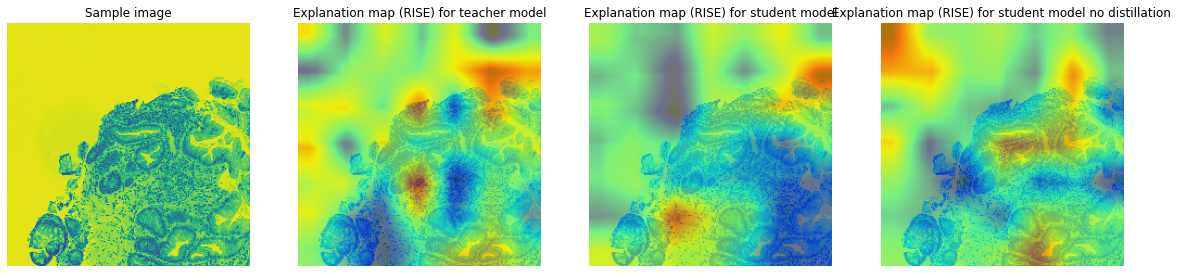

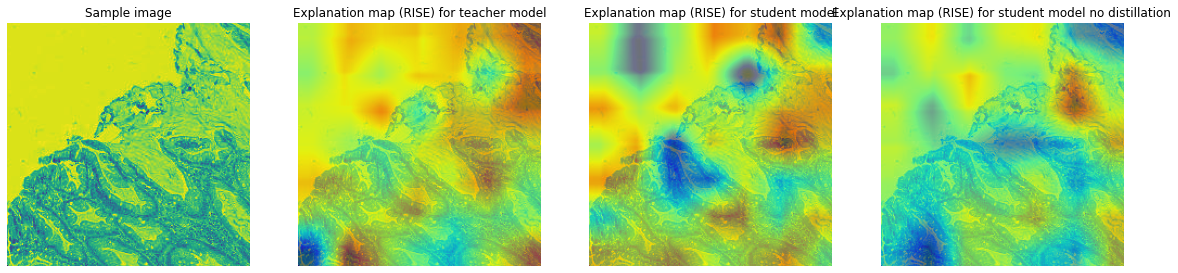

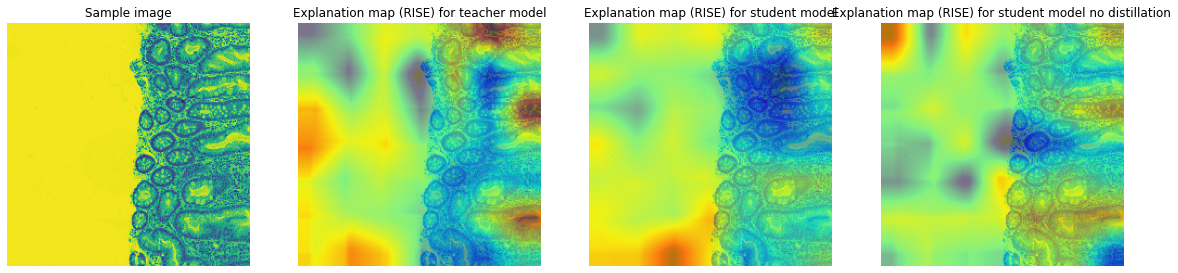

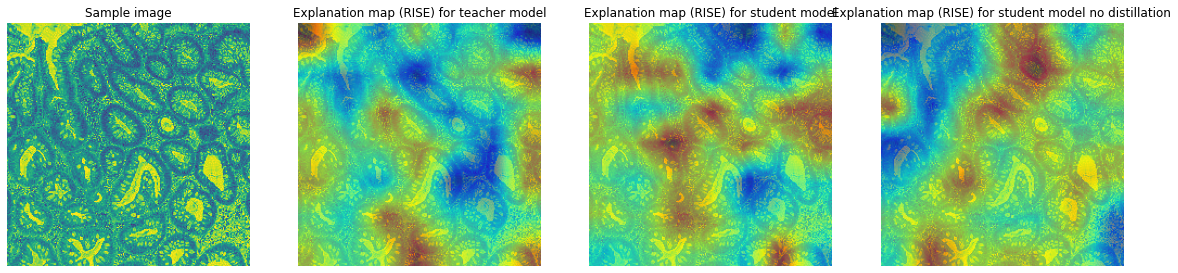

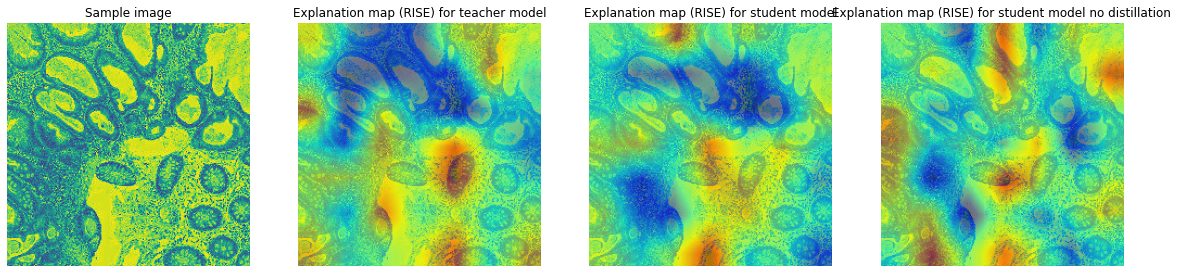

In [ ]:
for index in range(5):
    my_HMT_XAI_test(np_train_set[100:110,:,:,:], np_train_label[100:110,:], index)

In [ ]:
# total_train = np_train_set.shape[0]
# total_test = np_test_set.shape[0]
# for i in range(total_train//HMT_BATCH_SIZE+1):
#     # print (i)
#     # print(i*HMT_BATCH_SIZE,(i+1)*HMT_BATCH_SIZE+1)
#     begin_index = i*HMT_BATCH_SIZE
#     end_index = (i+1)*HMT_BATCH_SIZE
#     if(i==total_train//HMT_BATCH_SIZE):
#         end_index = total_train
#     for j in range(begin_index, end_index):
#         print(j)
#     # print(range(begin_index, end_index))
